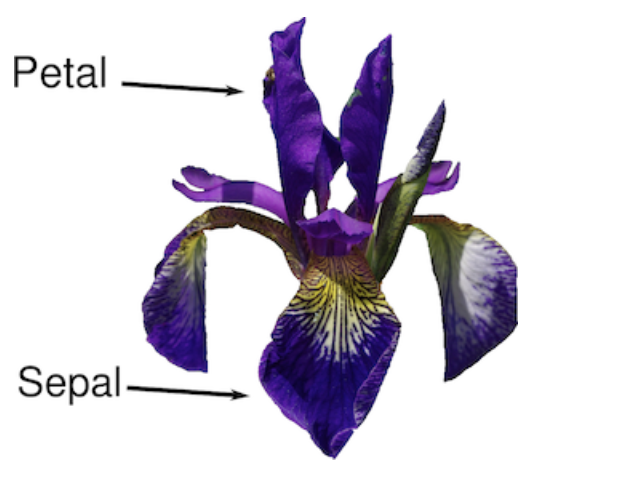

In [10]:
# !pip install mglearn

In [44]:
# https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-plants-dataset

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import mglearn
import pandas as pd
import numpy as np

In [45]:
iris_dataset = load_iris()
print(iris_dataset.keys())
print(iris_dataset["target_names"])
print(iris_dataset["feature_names"])

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])
['setosa' 'versicolor' 'virginica']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [46]:
# iris_df = pd.DataFrame(X_train, columns=iris_dataset.feature_names)
# grr = pd.plotting.scatter_matrix(iris_df, c=y_train, figsize=(15,15), marker='o', hist_kwds={'bins':20}, s=60, alpha=.8, cmap=mglearn.cm3)

In [47]:
def visualize_distribution(f_distr):
    fig, ax = plt.subplots(nrows = 4, figsize = (15, 15))
    plt.subplots_adjust(hspace = 0.4)
    # plt.xticks(rotation=45)

    title = ['sepal length', 'sepal width', 'petal length', 'petal width']
    
    for j in range(len(f_distr)):
        heights_0 = ax[j].bar(x = [f'[{i[0]}, {i[1]})' for i in f_distr[j].keys()], 
                            height = [h[0] for k, h in f_distr[j].items()], label = 'class 0')

        heights_1 = ax[j].bar(x = [f'[{i[0]}, {i[1]})' for i in f_distr[j].keys()], 
                            height = [h[1] for k, h in f_distr[j].items()], 
                            bottom = [h[0] for k, h in f_distr[j].items()], label = 'class 1')

        heights_2 = ax[j].bar(x = [f'[{i[0]}, {i[1]})' for i in f_distr[j].keys()], 
                            height = [h[2] for k, h in f_distr[j].items()], 
                            bottom = [h[0] + h[1] for k, h in f_distr[j].items()], label = 'class 2')


        ax[j].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
        ax[j].tick_params(axis='x', rotation=30)
        ax[j].legend()
        ax[j].set_title(title[j])

        for hght in [heights_0, heights_1, heights_2]:
            for bar in hght:
                w, h = bar.get_width(), bar.get_height()
                if h != 0:
                    ax[j].text(bar.get_x() + w/2, bar.get_y() + h/2, h, ha="center", va="center", color = 'white')


                    
def visualize_probability(f_distr_p):
    fig, ax = plt.subplots(nrows = 4, figsize = (15, 15))
    plt.subplots_adjust(hspace = 0.4)
    # plt.xticks(rotation=45)
    
    
    title = ['sepal length', 'sepal width', 'petal length', 'petal width']



    for j in range(len(f_distr_p)):
        heights_0 = ax[j].bar(x = [f'[{i[0]}, {i[1]})' for i in f_distr_p[j].keys()], 
                            height = [h[0] for k, h in f_distr_p[j].items()], label='class 0')

        heights_1 = ax[j].bar(x = [f'[{i[0]}, {i[1]})' for i in f_distr_p[j].keys()], 
                            height = [h[1] for k, h in f_distr_p[j].items()], 
                            bottom = [h[0] for k, h in f_distr_p[j].items()], label='class 1')

        heights_2 = ax[j].bar(x = [f'[{i[0]}, {i[1]})' for i in f_distr_p[j].keys()], 
                            height = [h[2] for k, h in f_distr_p[j].items()], 
                            bottom = [h[0] + h[1] for k, h in f_distr_p[j].items()], label='class 2')


        ax[j].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
        ax[j].tick_params(axis='x', rotation=30)
        # ax[j].set_xticklabels(rotation=30)
        ax[j].legend()        
        ax[j].set_title(title[j])

        for class_n, hght in enumerate([heights_0, heights_1, heights_2]):
            h_text = [v[class_n] for k, v in f_distr_p[j].items()]
            for i, bar in enumerate(hght):
                w, h = bar.get_width(), bar.get_height()
                if h != 0:
                    ax[j].text(bar.get_x() + w/2, bar.get_y() + h/2, h_text[i], ha="center", va="center", color = 'white')

In [48]:
class BayesClsfer:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
        self.X_train = None           # train data
        self.y_train = None           # train labels
        self.X_test = None            # test data
        self.y_test = None            # test labels
    
        
        self.x_axis = None            # descrete x-axis 
        self.step = None              # size of interval on x-axis  
        
        self.scaller = None           # scaller mulitplier for normalize data X
        self.bins = 10                # number of discret steps
        self.features_distrib = None  # distribution amoung features and classes by bins
        self.percentg_distrib = None  # probability amoung classes by bins
        self.n = X.shape[1]           # number of features
        self.m = None                 # number of examples
        self.n_c = len(set(y))        # number of classes
        
        self.eps = 1e-3               # substitude of 0 for small probabilities
    

    
    def train_test_split(self, train_portion = 0.8, shuffle = False):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, train_size=train_portion, random_state=0)
        self.m = self.X_train.shape[0]
        #print(self.X_train)

        
    def normalize(self, data = None):
        if data is None:
            self.scaller = np.max(self.X_train, axis = 0)
            self.X_train = self.X_train/self.scaller
            return self.scaller
        else:
            return data/self.scaller

        
        
    def binomizer(self, bins = 10):
        self.bins = bins
        
        self.step = round(1/bins,4)
        self.x_axis = [(round(i * self.step,2), round((i + 1) * self.step, 2)) for i in range(self.bins)]

        self.features_distrib = []
        self.percentg_distrib = []  

        for j in range(self.n):
            
            distr = {k: [0] * 3 for k in self.x_axis}
            for i,(x, y) in enumerate(zip(self.X_train[:, j], self.y_train)):
                distr[self.x_axis[int((x - self.eps)//self.step)]][y] += 1

            distr_p = dict()
            for k, vals in distr.items():
                distr_p[k] = list(np.round(np.array(vals)/sum(vals), 3)) if (sum(vals) != 0) else [self.eps, self.eps, self.eps]

            self.features_distrib.append(distr)
            self.percentg_distrib.append(distr_p)
        return self.features_distrib, self.percentg_distrib
    
    
    def init_probabilities(self):
        self.prob_c = None                       # probabilities that class = n_c    [#_class]
        self.prob_f = [None] * self.n            # probabilities that feature = n_f  [#_feature, #_bin]
        
        # probabilities that class = n_c given feature = n_f 
        self.prob_f_given_c = np.ones((self.n, self.n_c, len(self.x_axis)))  # [feature][class][#_bin]
        
        
        self.prob_c = [sum(self.y_train == i) / self.m for i in range(self.n_c)]
        self.qty_in_c = [sum(self.y_train == i) for i in range(self.n_c)]

        for f in range(self.n):
            self.prob_f[f] =  [sum(self.features_distrib[f][i])/self.m for i in self.features_distrib[f]]


        for f in range(self.n):
            for c in range(self.n_c):
                self.prob_f_given_c[f][c] = [v[c] for k, v in self.features_distrib[f].items()]
                self.prob_f_given_c[f][c] /= self.qty_in_c[c]
      
        
    def predict(self, x, verbose = False):
        x_norm = self.normalize(data = x)
        i_features = [(lambda x: min(x, self.bins - 1))(int(i)) for i in x_norm // self.step]
        x_features = [self.x_axis[i] for i in i_features]
        prob_features = np.ones((4,3))
        prob = np.ones((3,1))
        
        if verbose:
            print(f'Feature (original)  : {x}')
            print(f'Feature (normailzed): {x_norm}')
            print(f'Faeture (inervals)  : {x_features}')
            print(f'Feature (int index) : {i_features}')

        
        for f in range(self.n):
            f_bin = i_features[f]
            Z = 0
            for c in range(self.n_c):
                Z += self.prob_f_given_c[f][c][f_bin] * self.prob_c[c]
            if Z == 0:
                Z = self.eps
            
            for c in range(self.n_c):
                prob_features[f][c] = self.prob_f_given_c[f][c][f_bin] * self.prob_c[c] / Z
                if prob_features[f][c] == 0:
                    prob_features[f][c] = self.eps

        if verbose:
            print(f'\nProbability matrix:\n\n {prob_features}')
            pass
        
        for c in range(self.n_c):
            for i in range(self.n):
                prob[c] *= prob_features[i][c] 
        
        return(np.argmax(prob)), prob

In [49]:
X, y = iris_dataset['data'], iris_dataset['target']

_ = iris_bc = BayesClsfer(X, y)
_ = iris_bc.train_test_split(train_portion=0.8, shuffle = True)
_ = iris_bc.normalize()
_ = iris_bc.binomizer(bins = 10)
_ = iris_bc.init_probabilities()

### Checking single item

In [50]:
y_hat, prob = iris_bc.predict(iris_bc.X_test[0], verbose = True)
print('\nPredicted class:', y_hat)

print('\n',prob.reshape(-1))

print(f'\nPredicted class: {y_hat}, Original class: {iris_bc.y_test[0]}')

Feature (original)  : [5.8 2.8 5.1 2.4]
Feature (normailzed): [0.73417722 0.63636364 0.73913043 0.96      ]
Faeture (inervals)  : [(0.7, 0.8), (0.6, 0.7), (0.7, 0.8), (0.9, 1.0)]
Feature (int index) : [7, 6, 7, 9]

Probability matrix:

 [[0.08108108 0.56756757 0.35135135]
 [0.11111111 0.4        0.48888889]
 [0.001      0.16666667 0.83333333]
 [0.001      0.001      1.        ]]

Predicted class: 2

 [9.00900901e-09 3.78378378e-05 1.43143143e-01]

Predicted class: 2, Original class: 2


In [51]:
print('\nPredicted class: 2, Original class: 2')
print('\n[1.42857143e-10, 7.77777778e-05, 7.85714286e-02]')


Predicted class: 2, Original class: 2

[1.42857143e-10, 7.77777778e-05, 7.85714286e-02]


### Predicting classes for test bunch

In [52]:
predict = []
for x, y in zip(iris_bc.X_test, iris_bc.y_test):
    class_n, prob = iris_bc.predict(x, verbose = False)
    predict.append(class_n)
    print(f'predicterd class:  {class_n},  original class:  {y}')

print(f'\nNumber of correct answers: {sum([i[0] == i[1] for i in zip(predict, iris_bc.y_test)])} out of {len(iris_bc.y_test)}')

predicterd class:  2,  original class:  2
predicterd class:  1,  original class:  1
predicterd class:  0,  original class:  0
predicterd class:  2,  original class:  2
predicterd class:  0,  original class:  0
predicterd class:  2,  original class:  2
predicterd class:  0,  original class:  0
predicterd class:  1,  original class:  1
predicterd class:  1,  original class:  1
predicterd class:  1,  original class:  1
predicterd class:  2,  original class:  2
predicterd class:  1,  original class:  1
predicterd class:  1,  original class:  1
predicterd class:  1,  original class:  1
predicterd class:  1,  original class:  1
predicterd class:  0,  original class:  0
predicterd class:  1,  original class:  1
predicterd class:  1,  original class:  1
predicterd class:  0,  original class:  0
predicterd class:  0,  original class:  0
predicterd class:  2,  original class:  2
predicterd class:  1,  original class:  1
predicterd class:  0,  original class:  0
predicterd class:  0,  original cl

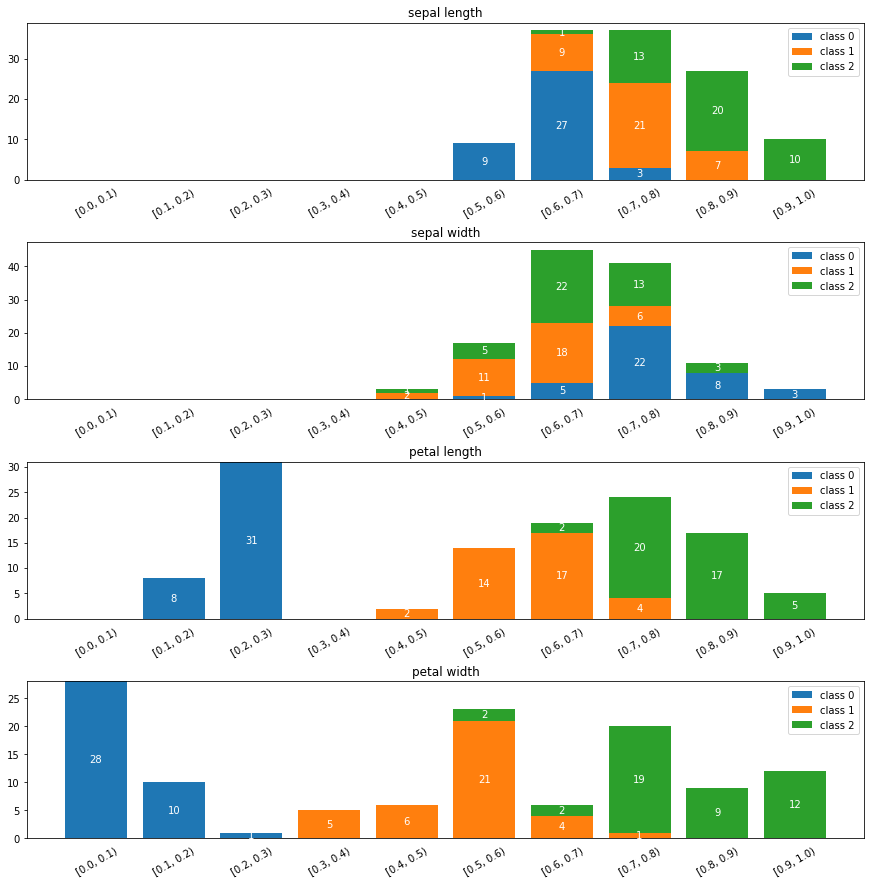

In [53]:
f_d = iris_bc.features_distrib
visualize_distribution(f_d)

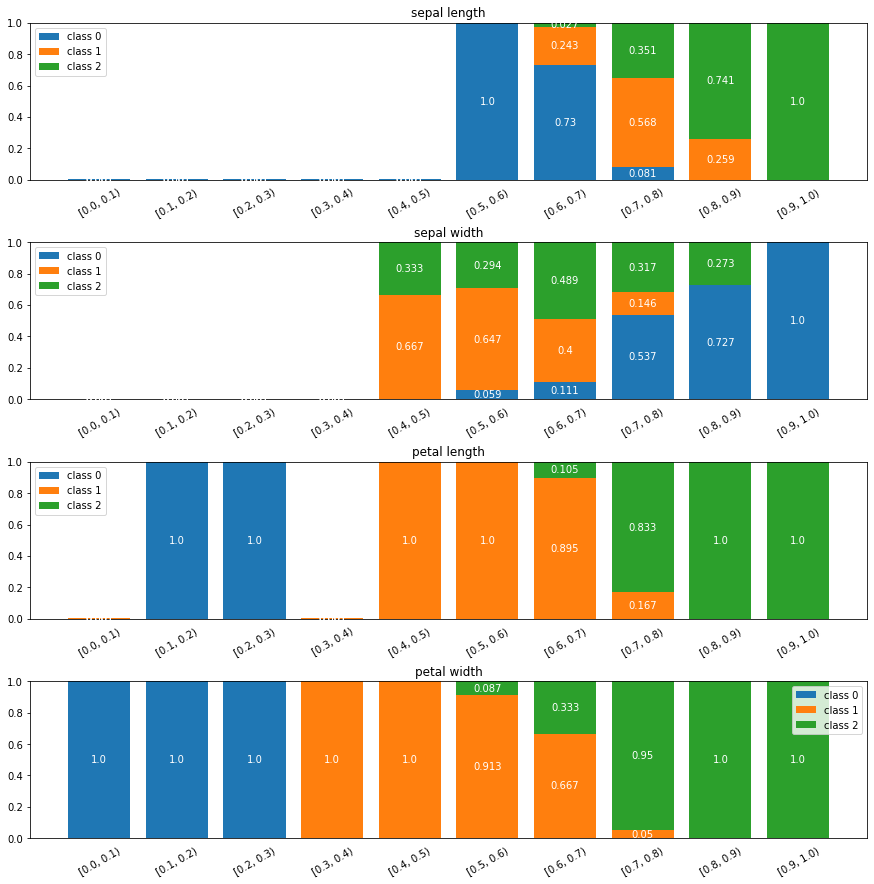

In [54]:
f_p = iris_bc.percentg_distrib
visualize_probability(f_p)